In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from datetime import datetime

### 데이터 로드

In [2]:
#데이터 로드
with open('../data/seoul/따릉이_대여이력_2019v2.pkl', 'rb') as f:
    df19 = pickle.load(f, encoding='utf-8')
with open('../data/seoul/따릉이_대여이력_2020v2.pkl', 'rb') as f:
    df20 = pickle.load(f, encoding='utf-8')
with open('../data/seoul/따릉이_대여이력_2021v2.pkl', 'rb') as f:
    df21 = pickle.load(f, encoding='utf-8')
with open('../data/seoul/따릉이_대여이력_202201-202205v2.pkl', 'rb') as f:
    df22 = pickle.load(f, encoding='utf-8')

# df19.reset_index(drop=True,inplace=True)
# df20.reset_index(drop=True,inplace=True)
# df21.reset_index(drop=True,inplace=True)
# df22.reset_index(drop=True,inplace=True)

In [3]:
# 형태 맞춰줌
df19['rent_id'] = df19['rent_id'].astype('int')
df19['return_id'] = df19['return_id'].astype('int')
df20['rent_id'] = df20['rent_id'].astype('int')
df20['return_id'] = df20['return_id'].astype('int')

In [4]:
df19.head()

,rent_id,rent_time,return_id,return_time,travel_time,travel_distance,fare,sex,age
0,1421,2019-01-01 00:00:44,1420,2019-01-01 00:03:53,189.0,580.0,BIL_004,\N,AGE_002
1,1408,2019-01-01 00:02:16,1433,2019-01-01 00:07:07,291.0,1020.0,BIL_002,F,AGE_005
2,347,2019-01-01 00:04:12,387,2019-01-01 00:07:07,175.0,550.0,BIL_014,M,AGE_003
3,615,2019-01-01 00:03:09,612,2019-01-01 00:07:27,258.0,700.0,BIL_002,\N,AGE_002
4,1177,2019-01-01 00:01:44,1152,2019-01-01 00:08:09,385.0,1090.0,BIL_006,\N,AGE_002


대여소 정보 불러오기

In [6]:
sta_info = pd.read_csv('../data/seoul/대여소정보_20220803.csv')

In [7]:
sta_info.head()

,stationId,ID,stationName,Y,X,Xn,Yn,Elev,start_date,end_date,BikeRoadNM,ToBikeRoad
0,ST-3,101,101. (구)합정동 주민센터,37.549561,126.905754,947509.050934,1.950191e+06,9.153730,2018-04-20,2021-03-05,한강자전거길,771.0
1,ST-4,102,102. 망원역 1번출구 앞,37.555649,126.910629,947943.924406,1.950863e+06,6.963620,2018-04-20,2022-05-31,홍제천자전거길,1065.0
2,ST-5,103,103. 망원역 2번출구 앞,37.554951,126.910835,947961.634042,1.950786e+06,6.865431,2018-04-20,2022-05-31,한강자전거길,1146.0
3,ST-6,104,104. 합정역 1번출구 앞,37.550629,126.914986,948325.239132,1.950304e+06,18.135445,2018-04-20,2022-05-30,한강자전거길,676.0
4,ST-7,105,105. 합정역 5번출구 앞,37.550007,126.914825,948310.657239,1.950235e+06,17.498493,2018-04-20,2022-05-31,한강자전거길,962.0


----

### 전처리

In [9]:
def remove_sta(df):
    df = df[(df['rent_id'].isin(sta_info['ID'])) & (df['return_id'].isin(sta_info['ID']))]
    df = df[~((df['rent_id'] == df['return_id']) & (df['travel_time']<120))]
    return df

In [10]:
df19 = remove_sta(df19)
df20 = remove_sta(df20)
df21 = remove_sta(df21)
df22 = remove_sta(df22)

In [12]:
#월 column 추가
df20['month'] = df20['rent_time'].dt.month
df19['month'] = df19['rent_time'].dt.month

#요일 column 추가 (월, 1 : 화, 2 : 수, 3 : 목, 4 : 금, 5 : 토, 6 : 일)
df20['weekday'] = df20['rent_time'].dt.weekday
df19['weekday'] = df19['rent_time'].dt.weekday

#시간 column 추가
df20['hour'] = df20['rent_time'].dt.hour
df19['hour'] = df19['rent_time'].dt.hour

#일
df20['day'] = df20['rent_time'].dt.day
df19['day'] = df19['rent_time'].dt.day

#### 기준에 맞추어 데이터 제거
* 1시간권 : 4시간 이상 도난/분실 간주 → travel_time이 1분미만, 4시간 이상 데이터 제거
* 2시간권 : 6시간 이상 도난/분실 간주 → travel_time이 1분미만, 6시간 이상 데이터 제거

In [13]:
def del_time_1(df):
    
    df = df[(df['fare'] == 'BIL_001') | (df['fare'] =='BIL_002') | (df['fare'] =='BIL_004')
     | (df['fare'] =='BIL_005')  | (df['fare'] =='BIL_006')  | (df['fare'] =='BIL_007') ]
    
    #1시간권 > 4시간 이상 도난/분실 간주
    index=df[(df['travel_time']<60) | (df['travel_time']>14400) ].index
    return df.drop(index)

def del_time_2(df):
    
    df = df[(df['fare'] == 'BIL_011') | (df['fare'] =='BIL_012') | (df['fare'] =='BIL_014')
     | (df['fare'] =='BIL_015')  | (df['fare'] =='BIL_016')  | (df['fare'] =='BIL_017') ]
    
    #2시간권 > 6시간 이상 도난/분실 간주
    index=df[(df['travel_time']<60) | (df['travel_time']>21600) ].index
    return df.drop(index)

In [14]:
df19 = pd.concat([del_time_1(df19), del_time_2(df19)], axis = 0)
df20 = pd.concat([del_time_1(df20), del_time_2(df20)], axis = 0)

#### 공휴일&주말 / 주중으로 데이터 분리

In [15]:
def hol_wek_19(df19):
    # 2019년 공휴일 따로 분리
    df19_hol = df19[((df19['month']==1) & (df19['day']==1)) | ((df19['month']==2) & (df19['day']==4))
                | ((df19['month']==2) & (df19['day']==5)) | ((df19['month']==2) & (df19['day']==6))
                | ((df19['month']==3) & (df19['day']==1)) | ((df19['month']==6) & (df19['day']==6))
                | ((df19['month']==8) & (df19['day']==15)) | ((df19['month']==9) & (df19['day']==12))
                | ((df19['month']==9) & (df19['day']==13)) | ((df19['month']==10) & (df19['day']==3))
                | ((df19['month']==10) & (df19['day']==9)) | ((df19['month']==12) & (df19['day']==25)) | (df19['weekday']>=5)]
    
    df19_wek = df19.drop(df19_hol.index)
    
    return df19_hol, df19_wek

def hol_wek_20(df20):
    # 2020년 공휴일 따로 분리
    df20_hol = df20[((df20['month']==1) & (df20['day']==1)) | ((df20['month']==1) & (df20['day']==24)) 
     | ((df20['month']==1) & (df20['day']==27)) | ((df20['month']==4) & (df20['day']==30)) 
     | ((df20['month']==5) & (df20['day']==5)) | ((df20['month']==8) & (df20['day']==17)) 
     | ((df20['month']==9) & (df20['day']==30)) | ((df20['month']==10) & (df20['day']==1)) 
     | ((df20['month']==10) & (df20['day']==2)) | ((df20['month']==10) & (df20['day']==9)) 
     | ((df20['month']==12) & (df20['day']==25)) | (df20['weekday']>=5)]
    
    df20_wek = df20.drop(df20_hol.index)
    
    return df20_hol, df20_wek

In [16]:
df19_hol, df19_wek = hol_wek_19(df19)
df20_hol, df20_wek = hol_wek_20(df20)

In [12]:
# df19_hol.to_csv('../data/seoul/df19_hol.csv',index=None)
# df19_wek.to_csv('../data/seoul/df19_wek.csv',index=None)

# df20_hol.to_csv('../data/seoul/df20_hol.csv',index=None)
# df20_wek.to_csv('../data/seoul/df20_wek.csv',index=None)

이용량

([<matplotlib.axis.XTick at 0x195a0824ca0>,
 [Text(0, 0, '19'), Text(1, 0, '20')])

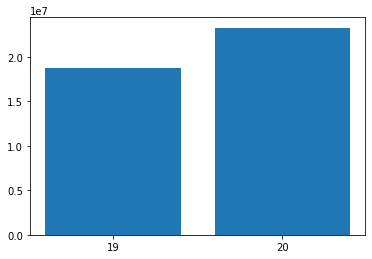

In [3]:
usage19 = len(df19_hol) + len(df19_wek)
usage20 = len(df20_hol) + len(df20_wek)
plt.bar(np.arange(2),[usage19,usage20])
plt.xticks(np.arange(2),['19','20'])

연도별로 나눠서 월별 이용량

## 히트맵 그려보기
#### 19 20년 비교

In [4]:
#비율 계산 함수
def Fare_valueRatio(df,a):
    return pd.DataFrame(df[a].value_counts()).sort_index()/len(df)

In [5]:
month7 = []
for i in range(1,13):
    for j in range(7):
        month7.append(i)
weekday12 = [x for x in range(1,8)]*12

In [11]:
df19_gb = df19.groupby(['month','weekday']).size()

In [12]:
df19_gbdf = pd.DataFrame({'month': month7,
                             'weekday': weekday12,
                             'count':list(df19_gb)})
df19_pivot = df19_gbdf.pivot('weekday', 'month', 'count')
df19_pivot.index = ['Mon','Tue','Wed','Thur','Fri','Sat','Sun']
df19_pivot

month,1,2,3,4,5,6,7,8,9,10,11,12
Mon,65596,67971,124765,269341,240432,316651,394970,255177,425008,250129,215638,160584
Tue,77823,66606,130688,253034,308899,295647,419723,291479,275438,410064,237086,142570
Wed,85169,79272,105094,185591,381502,321539,304385,258111,283205,356788,200212,128306
Thur,89095,81450,126173,167470,366663,281339,267970,304823,246045,402726,205377,119600
Fri,72943,62837,149512,185196,381937,293417,274546,373097,255089,355419,255911,121223
Sat,54089,60632,113806,192255,287727,376559,252333,341563,218376,313997,260656,95168
Sun,45539,45847,140407,186099,218122,361208,212576,236401,339866,302589,139807,102971


In [13]:
df20_gb = df20.groupby(['month','weekday']).size()

In [14]:
df20_gbdf = pd.DataFrame({'month': month7,
                             'weekday': weekday12,
                             'count':list(df20_gb)})
df20_pivot = df20_gbdf.pivot('weekday', 'month', 'count')
df20_pivot.index = ['Mon','Tue','Wed','Thur','Fri','Sat','Sun']
df20_pivot

month,1,2,3,4,5,6,7,8,9,10,11,12
Mon,86479,111900,259354,274574,294112,474045,233775,287936,321670,374359,352640,159977
Tue,91981,97790,236736,297543,284819,424247,340569,266809,523270,387282,291322,205424
Wed,135281,97934,207518,365402,362702,285744,390663,228765,355233,383481,267307,196009
Thur,157152,129164,154510,382000,368230,349767,410821,245543,394899,457280,269174,200418
Fri,142916,108418,194221,253062,356928,415611,459515,287647,403073,446014,297490,160977
Sat,87004,129794,206101,303353,356981,394087,393613,172231,381433,454151,259423,143721
Sun,81392,73781,235028,231108,405747,380537,309574,218353,382682,343469,227053,113154


Text(0.5, 0, 'Month')

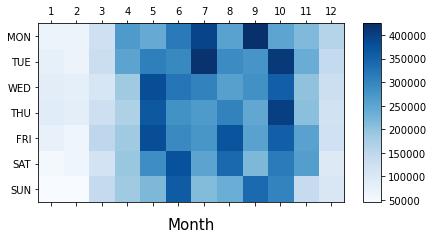

In [17]:
cmap = plt.get_cmap('Blues')

plt.matshow(df19_pivot, cmap=cmap)
plt.colorbar(shrink=0.8, aspect=10)
plt.xticks(np.arange(0,12),np.arange(1,13,1))
plt.yticks(np.arange(0,7),['MON','TUE','WED','THU','FRI','SAT','SUN'])
plt.xlabel('Month', labelpad = 15, fontdict = {'size' : 15})


# plt.clim(0,13000)

Text(0.5, 0, 'Month')

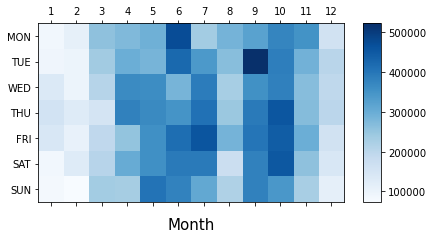

In [18]:
plt.matshow(df20_pivot, cmap=cmap)
plt.colorbar(shrink=0.8, aspect=10)
plt.xticks(np.arange(0,12),np.arange(1,13,1))
plt.yticks(np.arange(0,7),['MON','TUE','WED','THU','FRI','SAT','SUN'])
plt.xlabel('Month', labelpad = 15, fontdict = {'size' : 15})


# plt.clim(50000,500000)

In [22]:
# df19_pivot.to_csv('../data/seoul/df19_pivot.csv')
# df20_pivot.to_csv('../data/seoul/df20_pivot.csv')

------------------------------------

#### 시간별 대여량 비교(비율로 계산)	

In [26]:
hour_index=np.arange(0,24,1)

df19_hour = Fare_valueRatio(df19,'hour')
df20_hour = Fare_valueRatio(df20,'hour')

df19_hol_hour = Fare_valueRatio(df19_hol,'hour')
df20_hol_hour = Fare_valueRatio(df20_hol,'hour')

df19_wek_hour = Fare_valueRatio(df19_wek,'hour')
df20_wek_hour = Fare_valueRatio(df20_wek,'hour')

In [27]:
df_hour = pd.concat([df19_hour,df20_hour,df19_hol_hour,df20_hol_hour,df19_wek_hour,df20_wek_hour],axis=1)
df_hour.columns = ['19_all','20_all','19_hol','20_hol','19_wek','20_wek']

In [28]:
df_hour

,19_all,20_all,19_hol,20_hol,19_wek,20_wek
0,0.032691,0.027945,0.041529,0.033782,0.029212,0.025467
1,0.026661,0.021372,0.034585,0.026460,0.023541,0.019212
2,0.018829,0.014660,0.025920,0.018848,0.016037,0.012883
3,0.012936,0.010033,0.018833,0.013128,0.010615,0.008720
4,0.008023,0.006822,0.010984,0.008395,0.006857,0.006155
5,0.007715,0.007126,0.007455,0.006520,0.007817,0.007383
6,0.014430,0.013743,0.008825,0.008374,0.016636,0.016021
7,0.034751,0.032719,0.013539,0.013623,0.043102,0.040824
8,0.061323,0.053437,0.022473,0.022221,0.076618,0.066686
9,0.035500,0.033840,0.027537,0.028669,0.038635,0.036035


In [29]:
df_hour.to_csv('../data/seoul/df_hour.csv')

In [5]:
# 축 크기 설정
parameters = {'axes.labelsize': 13,
              'xtick.labelsize' : 13,
              'ytick.labelsize' : 13,
          'legend.fontsize': 12}
plt.rcParams.update(parameters)

In [6]:
hour_xname = [str(x) + 'AM' if x%4 == 0 else '' for x in range(12)] + ['12PM']+ [str(x) + 'PM' if x%4 == 0 else '' for x in range(1,12)]

In [7]:
hour_index=np.arange(0,24,1)

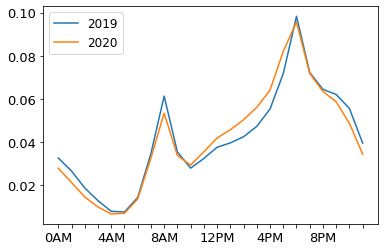

In [8]:
plt.plot(hour_index,df_hour['19_all'], label='2019')
plt.plot(hour_index,df_hour['20_all'], label='2020')
plt.xticks(hour_index,hour_xname)
plt.legend(loc=2)

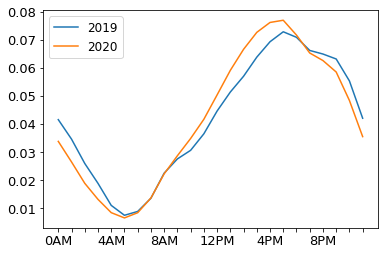

In [9]:
plt.plot(hour_index,df_hour['19_hol'], label='2019')
plt.plot(hour_index,df_hour['20_hol'], label='2020')
plt.xticks(hour_index,hour_xname)
plt.legend(loc=2)

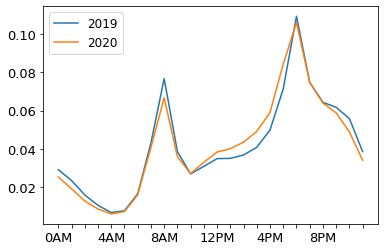

In [10]:
plt.plot(hour_index,df_hour['19_wek'], label='2019')
plt.plot(hour_index,df_hour['20_wek'], label='2020')
plt.xticks(hour_index,hour_xname)
# plt.xticks(hour_index)
# plt.yticks(np.arange(0,0.12,0.02))
plt.legend(loc=2)

이용시간
* 주중, 주말로 나누어서 나타냄, 10분 단위로 분포 확인

In [73]:
def travel_time_scope(x):
    if x<10:
        return 0
    elif x<20:
        return 10
    elif x<30:
        return 20
    elif x<40:
        return 30
    elif x<50:
        return 40
    elif x<60:
        return 50
    elif x<70:
        return 60
    elif x<80:
        return 70
    elif x<90:
        return 80
    elif x<100:
        return 90
    elif x<110:
        return 100
    else:
        return 110

In [74]:
th19_hol = (df19_hol['travel_time']/60).apply(travel_time_scope)
th20_hol = (df20_hol['travel_time']/60).apply(travel_time_scope)

In [75]:
th19_hol = (th19_hol.value_counts()/len(th19_hol)).sort_index()
th20_hol = (th20_hol.value_counts()/len(th20_hol)).sort_index()

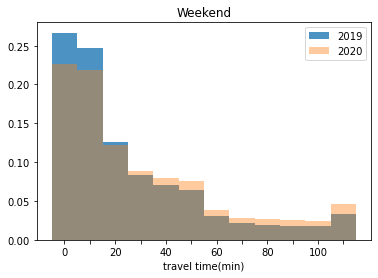

In [82]:
plt.bar(np.arange(12),th19_hol, alpha=0.8,width=1,label='2019')
plt.bar(np.arange(12),th20_hol,alpha=0.4, width=1,label='2020')
plt.xticks(np.arange(12),[0,'',20,'',40,'',60,'',80,'',100,''])
plt.xlabel('travel time(min)')
plt.title('Weekend')
plt.legend()

In [83]:
th19_wek = (df19_wek['travel_time']/60).apply(travel_time_scope)
th20_wek = (df20_wek['travel_time']/60).apply(travel_time_scope)

In [84]:
th19_wek = (th19_wek.value_counts()/len(th19_wek)).sort_index()
th20_wek = (th20_wek.value_counts()/len(th20_wek)).sort_index()

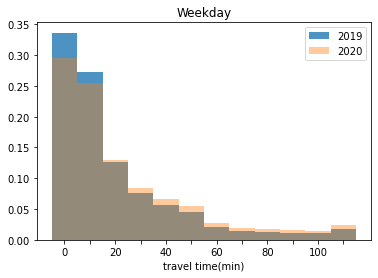

In [85]:
plt.bar(np.arange(12),th19_wek, alpha=0.8,width=1,label='2019')
plt.bar(np.arange(12),th20_wek,alpha=0.4, width=1,label='2020')
plt.xticks(np.arange(12),[0,'',20,'',40,'',60,'',80,'',100,''])
plt.xlabel('travel time(min)')
plt.title('Weekday')
plt.legend()